In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import time
import torch.nn as nn
import torch.optim as optim

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
class Load_Dataset(Dataset):
    def __init__(self, file):
        tx = np.loadtxt(file, delimiter=',', dtype=np.float64, skiprows=1)
        self.t = torch.from_numpy(tx[:,0]).float()
        self.x = torch.from_numpy(tx[:,1]).float()
        self.Tf = torch.from_numpy(tx[:,2]).float()
        self.n_samples = tx.shape[0]

    def __getitem__(self, index):
        return self.t[index], self.x[index], self.Tf[index]
    
    def __len__(self):
        return self.n_samples
    
    def create_input(self):
        return torch.stack((self.t, self.x), dim=1)

In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)


In [4]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_,
                 alpha_f_ = 0.005, h_f_ = 5,
                 T_hot_ = 4, T_cold_ = 1, T_0_ = 1, 
                 data_ = '/home/anna/AISE/projects/AISE/Project1/Task2/DataSolution.txt'):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        self.alpha_f = alpha_f_
        self.h_f = h_f_

        self.T_hot = T_hot_
        self.T_cold = T_cold_
        self.T_0 = T_0_

        self.dataset_name = data_
        self.dataset = Load_Dataset(self.dataset_name)

        # u_f in phases
        self.phases = [1, 0, -1, 0]
        self.phase_time = 1
        self.num_cycles = 2

        # Number of points for each phase
        self.n_sb_phase = self.n_sb // (len(self.phases) * self.num_cycles)


        # Extrema of the solution domain (t,x) in [0,1] x [0,8]
        self.domain = torch.tensor([[0, 8],  # Time dimension
                                    [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1
        self.time_dimensions = 1
        self.output_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Neural Network parameters
        self.n_hidden_layers = 5
        self.n_neurons = 25
        self.seed = 42

        self.approximate_solution_Tf = NeuralNet(input_dimension=self.space_dimensions + self.time_dimensions,
                                                 output_dimension=self.output_dimensions,
                                                 n_hidden_layers=self.n_hidden_layers,
                                                 neurons=self.n_neurons,
                                                 retrain_seed=self.seed)

        self.approximate_solution_Ts = NeuralNet(input_dimension=self.space_dimensions + self.time_dimensions,
                                                 output_dimension=self.output_dimensions,
                                                 n_hidden_layers=self.n_hidden_layers,
                                                 neurons=self.n_neurons,
                                                 retrain_seed=self.seed)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()


    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain.shape[0])
        return tens * (self.domain[:, 1] - self.domain[:, 0]) + self.domain[:, 0]
    
    def convert_subdomain(self, tens, subdomain):
        assert (tens.shape[1] == subdomain.shape[0])
        return tens * (subdomain[:, 1] - subdomain[:, 0]) + subdomain[:, 0]


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.full((input_tb.shape[0], 1), self.T_0)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain[1, 0]
        xL = self.domain[1, 1]

        input_sb_0 = torch.tensor([])
        input_sb_L = torch.tensor([])

        output_sb_0 = torch.tensor([])
        output_sb_L = torch.tensor([])

        # generate equal number of points for each phase
        for phase in range(len(self.phases) * self.num_cycles):

            subdomain = torch.tensor([[phase, phase + 1],  # Time dimension
                                        [0, 1]])  # Space dimension
            
            input_sb_sub = self.convert_subdomain(self.soboleng.draw(self.n_sb_phase), subdomain)

            input_sb_sub_0 = torch.clone(input_sb_sub)
            input_sb_sub_0[:, 1] = torch.full(input_sb_sub_0[:, 1].shape, x0)

            input_sb_sub_L = torch.clone(input_sb_sub)
            input_sb_sub_L[:, 1] = torch.full(input_sb_sub_L[:, 1].shape, xL)

            output_sb_sub_0 = torch.zeros((input_sb_sub_0.shape[0], 1))
            output_sb_sub_L = torch.zeros((input_sb_sub_0.shape[0], 1))

            # Output vales for different phases of the boundary
            curr_phase = self.phases[phase % len(self.phases)]

            if curr_phase == 1:
                output_sb_sub_0 = torch.full((input_sb_sub_0.shape[0], 1), self.T_hot)
            elif curr_phase == -1: 
                output_sb_sub_L = torch.full((input_sb_sub_L.shape[0], 1), self.T_cold)

            input_sb_0 = torch.cat((input_sb_0, input_sb_sub_0), 0)
            input_sb_L = torch.cat((input_sb_L, input_sb_sub_L), 0)

            output_sb_0 = torch.cat((output_sb_0, output_sb_sub_0), 0)
            output_sb_L = torch.cat((output_sb_L, output_sb_sub_L), 0)

        assert (input_sb_0.shape[0] == output_sb_0.shape[0])
        assert (input_sb_L.shape[0] == output_sb_L.shape[0])

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int


    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution_Tf(input_tb).reshape(-1, )
        return u_pred_tb
    
    def change_tensor_values(self, tensor, phase, value):
        lower_bound = phase * self.n_sb_phase
        upper_bound = (phase + 1) * self.n_sb_phase
        mask = (tensor >= lower_bound) & (tensor < upper_bound)
        tensor[mask] = value
        return tensor

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        input_sb.requires_grad = True

        u_pred_sb_Tf = self.approximate_solution_Tf(input_sb).reshape(-1, )
        xgradient_Tf = torch.autograd.grad(u_pred_sb_Tf.sum(), input_sb, create_graph=True)[0][:,1]

        midpoint_Tf = int(len(input_sb[:, 1]) / 2)

        gradu_Tf_0 = xgradient_Tf.clone()
        gradu_Tf_L = xgradient_Tf.clone()

        # Change boundary in different phase regions
        for phase in range(len(self.phases) * self.num_cycles):
            # Output vales for different phases of the boundary
            curr_phase = self.phases[phase % len(self.phases)]

            #g Get current region of the boundary
            lower_bound = phase * self.n_sb_phase
            upper_bound = (phase + 1) * self.n_sb_phase
            mask = (gradu_Tf_0 >= lower_bound) & (gradu_Tf_0 < upper_bound)

            if curr_phase == 1:
                gradu_Tf_0[mask] = u_pred_sb_Tf[mask]
            elif curr_phase == -1: 
                gradu_Tf_L[mask] = u_pred_sb_Tf[mask]

        u_pred_Tf_boundary = torch.cat([gradu_Tf_0[:midpoint_Tf], gradu_Tf_L[midpoint_Tf:]], 0)

        return u_pred_Tf_boundary


    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True

        U_f = torch.zeros(input_int.shape[0])

        for phase in range(len(self.phases) * self.num_cycles):
            # Output vales for different phases of the boundary
            curr_phase = self.phases[phase % len(self.phases)]

            #g Get current region of the boundary
            lower_bound = phase * self.n_sb_phase
            upper_bound = (phase + 1) * self.n_sb_phase
            mask = (U_f >= lower_bound) & (U_f < upper_bound)

            U_f[mask] = curr_phase

        
        Tf = self.approximate_solution_Tf(input_int).reshape(-1,)
        Ts = self.approximate_solution_Ts(input_int).reshape(-1,)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_Tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_Tf_t = grad_Tf[:, 0]
        grad_Tf_x = grad_Tf[:, 1]
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:, 1]

        residual = grad_Tf_t + U_f*grad_Tf_x - self.alpha_f * grad_Tf_xx + self.h_f*(Tf - Ts)

        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb).reshape(-1, 1)
        u_pred_tb = self.apply_initial_condition(inp_train_tb).reshape(-1, 1)

        inp_train_meas = self.dataset.create_input().to(self.device)
        
        u_train_meas = torch.unsqueeze(self.dataset.Tf, dim=1).to(self.device)
        u_pred_meas_tot = self.approximate_solution_Tf(inp_train_meas)
        u_pred_meas = u_pred_meas_tot[:,0].reshape(-1,1) # Fluid

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        r_meas = u_train_meas - u_pred_meas

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        loss_u = loss_sb + loss_tb + loss_meas

        loss = torch.log10(self.lambda_u * loss_u + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(loss_u).item(), 4))

        return loss

In [5]:
def fit(model, num_epochs, optimizer, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(model.training_set_sb, model.training_set_tb, model.training_set_int)):
            def closure():
                optimizer.zero_grad()
                loss = model.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                loss.backward()

                history.append(loss.item())
                return loss

            optimizer.step(closure=closure)

    print('Final Loss: ', history[-1])

    return history

In [6]:
def plotting(model):
      inputs = model.soboleng.draw(100000)
      inputs = model.convert(inputs)

      Tf_approx = model.approximate_solution_Tf(inputs)
      Ts_approx = model.approximate_solution_Ts(inputs)

      fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
      im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=Tf_approx.detach(), cmap="jet")
      axs[0].set_xlabel("x")
      axs[0].set_ylabel("t")
      plt.colorbar(im1, ax=axs[0])
      axs[0].grid(True, which="both", ls=":")
      im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=Ts_approx.detach(), cmap="jet")
      axs[1].set_xlabel("x")
      axs[1].set_ylabel("t")
      plt.colorbar(im2, ax=axs[1])
      axs[1].grid(True, which="both", ls=":")
      axs[0].set_title("Approximate Solution Fluid")
      axs[1].set_title("Approximate Solution Solid")

      plt.show()

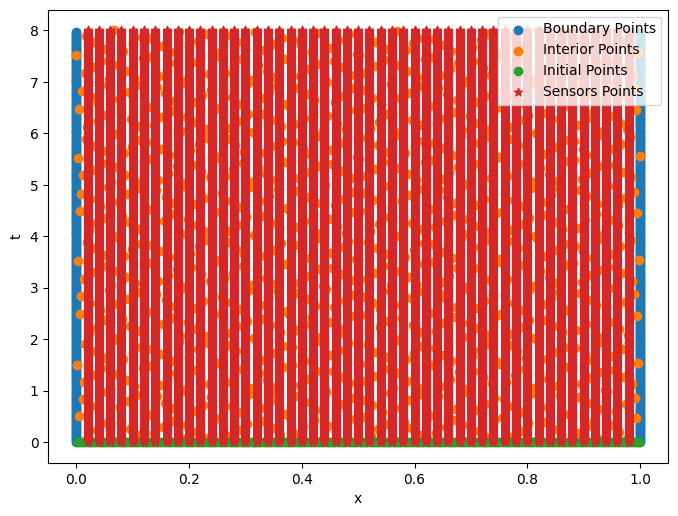

In [7]:


# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 1024
n_sb = 256
n_tb = 256

pinn = Pinns(n_int, n_sb, n_tb)
     

# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_meas_ = pinn.dataset.create_input()
output_meas_ = pinn.dataset.Tf

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_meas_[:, 1].detach().numpy(), input_meas_[:, 0].detach().numpy(), label="Sensors Points", marker="*")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

################################  0  ################################
Total loss:  1.7471 | PDE Loss:  -0.3104 | Function Loss:  0.7432
Total loss:  1.6966 | PDE Loss:  -0.142 | Function Loss:  0.6903
Total loss:  1.5746 | PDE Loss:  0.4517 | Function Loss:  0.5406
Total loss:  1.5324 | PDE Loss:  0.4492 | Function Loss:  0.4949
Total loss:  1.3772 | PDE Loss:  0.2622 | Function Loss:  0.3425
Total loss:  1.3929 | PDE Loss:  -0.201 | Function Loss:  0.3816
Total loss:  1.3532 | PDE Loss:  -0.061 | Function Loss:  0.3361
Total loss:  1.3279 | PDE Loss:  -0.1543 | Function Loss:  0.3133
Total loss:  1.3174 | PDE Loss:  -0.2307 | Function Loss:  0.305
Total loss:  1.3089 | PDE Loss:  -0.3158 | Function Loss:  0.2985
Total loss:  1.3068 | PDE Loss:  -0.3397 | Function Loss:  0.2968
Total loss:  1.3056 | PDE Loss:  -0.3543 | Function Loss:  0.296
Total loss:  1.3043 | PDE Loss:  -0.372 | Function Loss:  0.2951
Total loss:  1.3025 | PDE Loss:  -0.3992 | Function Loss:  0.2937
Total loss:  1.

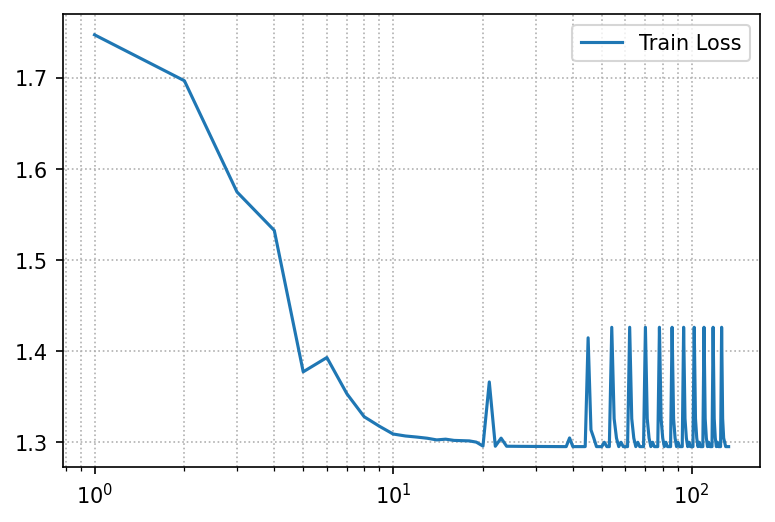

In [8]:


n_epochs = 1
max_iter = 1000
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution_Tf.parameters()) + list(pinn.approximate_solution_Ts.parameters()),
                              lr=float(0.5),
                              max_iter=max_iter,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)                               

optimizer_ADAM = optim.Adam(list(pinn.approximate_solution_Tf.parameters()) + list(pinn.approximate_solution_Ts.parameters()),
                            lr=float(0.005))
     

hist = fit(pinn,
          num_epochs=n_epochs,
          optimizer=optimizer_LBFGS,
          verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

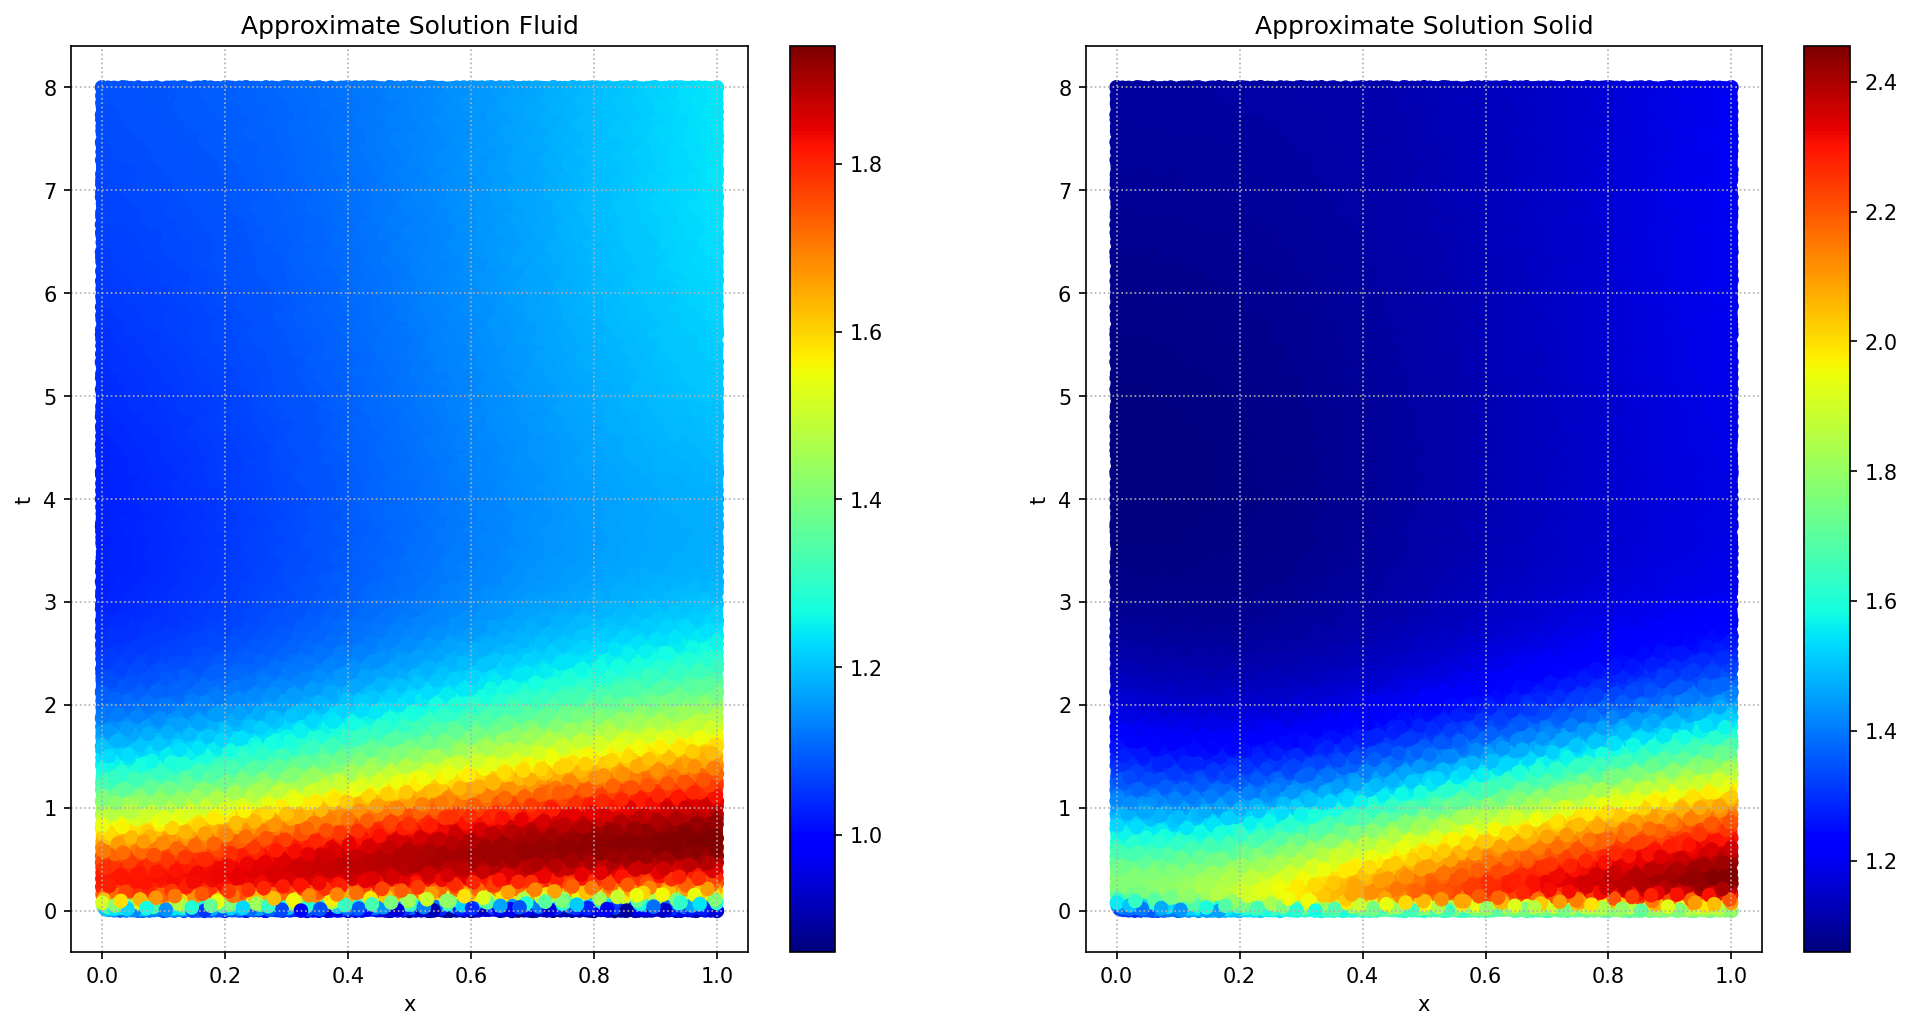

In [9]:
plotting(pinn)